In [1]:
import pickle
import os

file_path = 'data/stage3_batch_response_v2.pkl'

if os.path.exists(file_path):
   with open(file_path, 'rb') as f:
       stage3_batch_response = pickle.load(f)

In [5]:
from src.client import ASOClient
client = ASOClient(model='gpt-5-mini', verbosity='low', reasoning_effort='low', service_tier="default")

stage4_batch_str = client.create_stage4_batch_str(
    custom_ids=[response['custom_id'] for response in stage3_batch_response],
    n_files = 1000000,
)
stage4_batch_response = client.test_batch_request(stage4_batch_str)

Processing Test Batch: 100%|██████████| 5054/5054 [09:38<00:00,  8.74it/s]


In [6]:
import pickle
import os

file_path = 'data/stage4_batch_response_v2.pkl'

if os.path.exists(file_path):
   with open(file_path, 'rb') as f:
       stage4_batch_response = pickle.load(f)
else:
   with open(file_path, 'wb') as f:
       pickle.dump(stage4_batch_response, f)

In [7]:
import pandas as pd
import json

data_list = []

# Iterate through each response
for item in stage4_batch_response:  # Assuming your data is stored in a variable called 'responses'
    custom_id = item['custom_id']
    
    # Extract the JSON content from the response
    content = json.loads(item['response']['body']['output'][1]['content'][0]['text'])
    
    # Add custom_id to the parsed content
    content['custom_id'] = custom_id
    
    # Append to the data list
    data_list.append(content)

metadata_df = pd.DataFrame(data_list)
metadata_df = metadata_df.replace(["NA", -1], pd.NA)
metadata_df

,target_mrna,target_gene,cell_line,cell_line_species,dosage,cells_per_well,transfection_method,custom_id
0,APP,APP,SH-SY5Y,human,4000.0,20000,Electroporation,patent-scrape-v2/data/inhibition_tables/US2023...
1,PKK,KLKB1,HepaRG,human,5000.0,20000,Electroporation,patent-scrape-v2/data/inhibition_tables/US2017...
2,ATXN2,ATXN2,A431,human,6000.0,10000,Electroporation,patent-scrape-v2/data/inhibition_tables/US2024...
3,PTPRU,PTPRU,RAW 264.7,mouse,100.0,<NA>,Lipofection,patent-scrape-v2/data/inhibition_tables/US2011...
4,apo(a),LPA,primary hepatocytes,mouse,1000.0,35000,Electroporation,patent-scrape-v2/data/inhibition_tables/US2024...
...,...,...,...,...,...,...,...,...
5049,ATXN2,ATXN2,A431,human,6000.0,10000,Electroporation,patent-scrape-v2/data/inhibition_tables/US2024...
5050,apo(a),LPA,<NA>,mouse,1000.0,35000,Electroporation,patent-scrape-v2/data/inhibition_tables/US2024...
5051,Factor 7,F7,<NA>,other,<NA>,<NA>,Other,patent-scrape-v2/data/inhibition_tables/US2012...
5052,PIM-1,PIM1,A549,human,<NA>,<NA>,Other,patent-scrape-v2/data/inhibition_tables/US2004...


In [8]:
with open('data/aso_inhibitions_13_08_25.pkl', 'rb') as f:
    main_df = pickle.load(f)

#merge with metadata_df on custom_id:
main_df = main_df.merge(metadata_df, on='custom_id', how='left')

In [13]:
def check_steric(chemistry):
    if chemistry is None:
        return False

    for modification in chemistry.modifications:
        if modification.modification == 'MOE' and len(modification.positions)  == chemistry.length:
            return True
    else:
        return False
    
main_df['steric_blocking'] = main_df['chemistry'].apply(check_steric)

In [14]:
# List of files to exclude
exclude_patterns = [
    'patent-scrape-v2/data/inhibition_tables/US20090318532A1_table_00075.xml',
    'patent-scrape-v2/data/inhibition_tables/US20230114930A1_table_00005.xml',
    'patent-scrape-v2/data/inhibition_tables/US20190382760A1_table_00013.xml',
    'patent-scrape-v2/data/inhibition_tables/US20230357776A1_table_00120.xml',
    'patent-scrape-v2/data/inhibition_tables/US20220112503A1_table_00011.xml',
    #'patent-scrape-v2/data/inhibition_tables/US20250109396A1',
    #'patent-scrape-v2/data/inhibition_tables/US20210252039A1',  these are splice switching ASO's.
    #'patent-scrape-v2/data/inhibition_tables/US20180127751A1',
]

# Filter out rows where file_path starts with any of the patterns
mask = ~main_df['custom_id'].str.startswith(tuple(exclude_patterns))
main_df = main_df[mask]

# exclude any rows below -500 - there are a number of inhibitions which are really just IDs?
main_df = main_df[main_df['inhibition_percent'] > -1000]

with open('data/aso_inhibitions_21_08_25_incl_metadata_df.pkl', 'wb') as f:
    pickle.dump(main_df, f)

In [7]:
# Calculate and print mean inhibition by transfection_method with sample counts
grouped = main_df.groupby('transfection_method')
mean_inhibition_by_method = grouped['inhibition_percent'].mean().sort_values(ascending=False)
counts_by_method = grouped['inhibition_percent'].count()

# Create a formatted output with N values
print("Mean inhibition percentage by transfection method:")
for method in mean_inhibition_by_method.index:
    print(f"{method}: {mean_inhibition_by_method[method]:.2f}% (N={counts_by_method[method]})")

Mean inhibition percentage by transfection method:
Other: 52.73% (N=28687)
Lipofection: 48.43% (N=11342)
Electroporation: 41.80% (N=95606)
Gymnosis: 40.63% (N=53765)


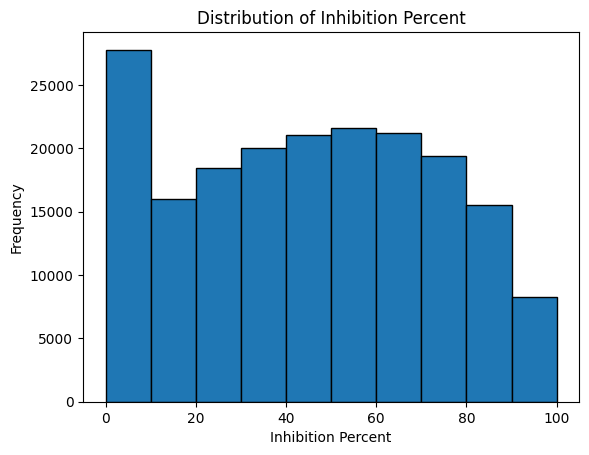

In [8]:
import matplotlib.pyplot as plt


main_df['inhibition_percent'].clip(0,100).plot(kind='hist', bins=10, edgecolor='black')
plt.xlabel('Inhibition Percent')
plt.ylabel('Frequency')
plt.title('Distribution of Inhibition Percent')
plt.show()

In [7]:
import pickle

with open('data/aso_inhibitions_incl_metadata_df.pkl', 'rb') as f:
    metadata_df = pickle.load(f)

In [8]:
genes_of_interest = {
    "RHOBTB2", "EIF2AK2", "TUBB4A", "KCNT1", "FGF12", "GFAP", 
    "ITM2B", "CDK19", "KCNT2", "RABT1B", "GCDH", "NDUFS8", 
    "C12orf57", "ACADS", "ARSG", "PYY3R2", "ERLIN2", "NDUFA1", 
    "MFSD2A", "SLC25A22", "GJC2"
}

# Get the set of target genes from metadata_df
target_genes = set(metadata_df.target_mrna)

# Find the overlap between the two sets
overlap = genes_of_interest.intersection(target_genes)

# Show the overlap
print(f"Number of overlapping genes: {len(overlap)}")
print("Overlapping genes:")
for gene in sorted(overlap):
    print(f"- {gene}")

Number of overlapping genes: 0
Overlapping genes:
